## 🌐 *Neural Networks*

## 🌦️ **CAC II - Weather Forecasting**

### 👨‍🎓 Sankar Murugan 

### 🏫 4 - MSc DS A

### 🆔 23122031


---
---

# 🌦️ Weather Forecasting Mini-Project Overview

## 🔍 **Purpose** 
Develop a machine learning-based weather forecasting system for specific locations.

---

## ⭐ **Key Features** 
- 📡 **Real-Time Weather Data**: Fetches live data using OpenWeatherMap API
- 🌐 **Geocoding**: Converts location names to coordinates using the OpenCage API
- 🤖 **LSTM Neural Network**: Implements an LSTM model for weather predictions
- 🗄️ **SQL Server Database**: Stores historical and predicted weather data
- 📊 **Visualization**: Provides forecast graphs using Matplotlib
- 📈 **Accuracy Metrics**: Tracks and displays prediction accuracy

---

## 🧩 **Main Components** 
1. **Data Collection**:
   - 🌡️ Retrieves weather data (temperature, humidity, wind speed)
   - ⏲️ Updates data periodically (hourly in the current setup)
  
2. **Machine Learning Model**:
   - 🧠 LSTM model built with Keras/TensorFlow
   - 📚 Trained on historical weather data for future predictions

3. **Database Integration**:
   - 🗄️ Stores weather forecasts and accuracy metrics in SQL Server
  
4. **Visualization**:
   - 📈 Plots comparing actual vs. predicted weather data
  
5. **Geolocation**:
   - 🌍 Converts user-input locations into latitude/longitude

---

## 🔄 **Workflow** 
1. 🏙️ **User inputs a location**
2. ☁️ **System fetches current weather data**
3. 🧠 **Model trains on historical data & makes predictions**
4. 💾 **Results stored in the database and visualized**
5. 🔄 **Updates every hour for continuous forecast**

---

## 🛠️ **Technical Stack** 
- 🐍 **Python**
- 🤖 **TensorFlow/Keras** for machine learning
- 🧮 **Pandas** for data manipulation
- 📊 **Matplotlib** for visualization
- 💾 **pyodbc** for database connectivity
- 🌐 **APIs**: OpenWeatherMap, OpenCage

---

## 🚀 **Future Potential** 
- 🖥️ **Web Interface** for user interaction
- 🎯 **Improved models** for better accuracy
- 🌍 **Longer-term forecasts** and additional parameters


In [1]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import pyodbc
import logging
import os
from tensorflow.keras.layers import Input

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# API keys and connection string (use environment variables in production)
OPENWEATHERMAP_API_KEY = "89ebda4212ca2617ce13bd8f58d96364"
MAPBOX_ACCESS_TOKEN = "pk.eyJ1Ijoic2Fua2FyLW11cnVnYW4wMDciLCJhIjoiY20yNXUyNXlpMHMzbjJqcXNyYjd2eWZweiJ9.ISGPwkUj8-HCHr0wF6e3yQ"
OPENCAGE_API_KEY = "1f51abb4fc034ef7a2854d8cebcbfd00"

SQL_CONNECTION_STRING = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=MEMRS;"
    "DATABASE=climate;"
    "Trusted_Connection=yes;"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)

In [3]:
def get_coordinates(location):
    base_url = "https://api.opencagedata.com/geocode/v1/json"
    params = {'q': location, 'key': OPENCAGE_API_KEY, 'limit': 1}
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        results = response.json().get('results', [])
        if results:
            return results[0]['geometry']['lat'], results[0]['geometry']['lng']
        else:
            logging.warning(f"No coordinates found for location: {location}")
            return None, None
    except requests.RequestException as e:
        logging.error(f"Error fetching coordinates: {e}")
        return None, None

def get_weather_data(location):
    lat, lon = get_coordinates(location)
    if lat is None or lon is None:
        return None
    base_url = "https://api.openweathermap.org/data/2.5/forecast"
    params = {
        'lat': lat, 'lon': lon, 'appid': OPENWEATHERMAP_API_KEY, 'units': 'metric'
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        logging.error(f"Error fetching weather data: {e}")
        return None

def process_weather_data(weather_data):
    if not weather_data or 'list' not in weather_data:
        return pd.DataFrame()
    records = [{
        'temp': entry['main']['temp'],
        'humidity': entry['main']['humidity'],
        'wind_speed': entry['wind']['speed'],
        'description': entry['weather'][0]['description'],
        'dt': pd.to_datetime(entry['dt'], unit='s')
    } for entry in weather_data['list']]
    return pd.DataFrame(records)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def build_model(seq_length, features):
    inputs = Input(shape=(seq_length, features))
    x = LSTM(100, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(features)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [4]:
class WeatherForecaster:
    def __init__(self, location):
        self.location = location
        self.lat, self.lon = get_coordinates(location)
        if self.lat is None or self.lon is None:
            raise ValueError(f"Invalid location: {location}")
        self.model = None
        self.scaler = MinMaxScaler()
        self.data = pd.DataFrame()
        self.conn = pyodbc.connect(SQL_CONNECTION_STRING)
        self.create_database_table()
        self.load_or_create_model()

    def create_database_table(self):
        cursor = self.conn.cursor()
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='weather_forecasts' AND xtype='U')
            CREATE TABLE weather_forecasts (
                id INT IDENTITY(1,1) PRIMARY KEY,
                location NVARCHAR(100),
                timestamp DATETIME,
                current_temp FLOAT,
                current_humidity FLOAT,
                current_wind_speed FLOAT,
                predicted_temp FLOAT,
                predicted_humidity FLOAT,
                predicted_wind_speed FLOAT,
                accuracy FLOAT,
                map_link NVARCHAR(200)
            )
        """)
        self.conn.commit()

    def load_or_create_model(self):
        model_path = 'weather_forecast_model.keras'
        if os.path.exists(model_path):
            self.model = load_model(model_path)
            logging.info("Loaded existing model.")
        else:
            self.model = build_model(24, 3)
            logging.info("Created new model.")

    def update_data(self):
        new_data = get_weather_data(self.location)
        if new_data is None:
            logging.warning("Failed to update weather data")
            return False
        new_df = process_weather_data(new_data)
        if new_df.empty:
            logging.warning("No new weather data found")
            return False
        self.data = pd.concat([self.data, new_df]).drop_duplicates().sort_values('dt').tail(1000)
        self.current_weather = new_df.iloc[0].to_dict()
        return True

    def train_model(self):
        if len(self.data) < 25:  # Changed from 24 to 25
            logging.warning("Not enough data to train the model")
            return

        scaled_data = self.scaler.fit_transform(self.data[['temp', 'humidity', 'wind_speed']])
        X, y = create_sequences(scaled_data, 24)

        # Ensure X and y have the same number of samples
        X = X[:-1]  # Remove the last sequence
        y = y[1:]   # Remove the first label

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('weather_forecast_model.keras', save_best_only=True)

        history = self.model.fit(
            X, y, 
            epochs=100, 
            batch_size=32, 
            validation_split=0.2, 
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )

        self.plot_training_history(history)

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        # plt.savefig('training_history.png')
        plt.show()
        plt.close()

    def make_prediction(self):
        if len(self.data) < 24:
            logging.warning("Not enough data to make a prediction")
            return None
        latest_data = self.data.tail(24)[['temp', 'humidity', 'wind_speed']].values
        scaled_data = self.scaler.transform(latest_data)
        prediction = self.model.predict(scaled_data[np.newaxis, :])
        return self.scaler.inverse_transform(prediction).squeeze()

    def calculate_accuracy(self, actual, predicted):
        r2 = r2_score(actual, predicted)
        return  r2

    def save_forecast(self, predicted,  r2):
        map_link = f"https://www.google.com/maps/@{self.lat},{self.lon},10z"
        cursor = self.conn.cursor()
            # Log the data being stored
        print("Storing the following data in the database:")
        print(f"Location: {self.location}")
        print(f"Timestamp: {datetime.now()}")
        print(f"Current Temperature: {self.current_weather['temp']:.2f}°C")
        print(f"Current Humidity: {self.current_weather['humidity']:.2f}%")
        print(f"Current Wind Speed: {self.current_weather['wind_speed']:.2f} m/s")
        print(f"Predicted Temperature: {predicted[0]:.2f}°C")
        print(f"Predicted Humidity: {predicted[1]:.2f}%")
        print(f"Predicted Wind Speed: {predicted[2]:.2f} m/s")
        print(f"Forecast Accuracy: {r2:.2f}")
        print(f"Map Link: {map_link}")
        cursor.execute("""
            INSERT INTO weather_forecasts (location, timestamp, current_temp, current_humidity, current_wind_speed,
                                           predicted_temp, predicted_humidity, predicted_wind_speed, accuracy, map_link)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (self.location, datetime.now(), float(self.current_weather['temp']), 
              float(self.current_weather['humidity']), float(self.current_weather['wind_speed']),
              float(predicted[0]), float(predicted[1]), float(predicted[2]), float(r2), map_link))
        self.conn.commit()

    def visualize_forecast(self, actual, predicted):
        plt.figure(figsize=(12, 6))
        indices = range(len(actual))
        plt.plot(indices, actual[:, 0], label='Actual Temperature', marker='o')
        plt.plot(indices, predicted[:, 0], label='Predicted Temperature', marker='x')
        plt.title(f'Temperature Forecast for {self.location}')
        plt.xlabel('Time Steps')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        # plt.savefig('temperature_forecast.png')
        plt.show()
        plt.close()

    def run_forecast(self):
        if not self.update_data():
            logging.error("Failed to update weather data. Forecast not generated.")
            return

        self.train_model()

        actual = self.data[['temp', 'humidity', 'wind_speed']].values[-25:]  # Changed from -24 to -25
        X_test = actual[:-1].reshape(1, 24, 3)  # Prepare input for prediction
        y_test = actual[-1]  # True values to compare with prediction

        predicted = self.make_prediction()
        if predicted is None:
            logging.error("Failed to make prediction.")
            return

        r2 = self.calculate_accuracy(y_test, predicted)
        self.save_forecast(predicted,  r2)
        self.visualize_forecast(actual, np.vstack((X_test.reshape(24, 3), predicted)))

        logging.info(f"Forecast completed with R2 score: {r2:.2f}")

    def close_connection(self):
        self.conn.close()



2024-10-13 02:34:34,267 - INFO - Loaded existing model.


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1523 - mae: 0.3229 - val_loss: 0.0593 - val_mae: 0.2173
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1451 - mae: 0.3112 - val_loss: 0.0514 - val_mae: 0.1795
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1135 - mae: 0.2582 - val_loss: 0.0481 - val_mae: 0.1681
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0922 - mae: 0.2148 - val_loss: 0.0497 - val_mae: 0.1824
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0714 - mae: 0.1983 - val_loss: 0.0566 - val_mae: 0.2149
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0838 - mae: 0.2276 - val_loss: 0.0652 - val_mae: 0.2413
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0951 - mae: 0.2573 - val_loss: 0.0624 - val_mae: 0.2326
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0820 - mae: 0.2413 - val_loss: 0.0579 - val_mae: 0.2190
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0646 - mae: 0.

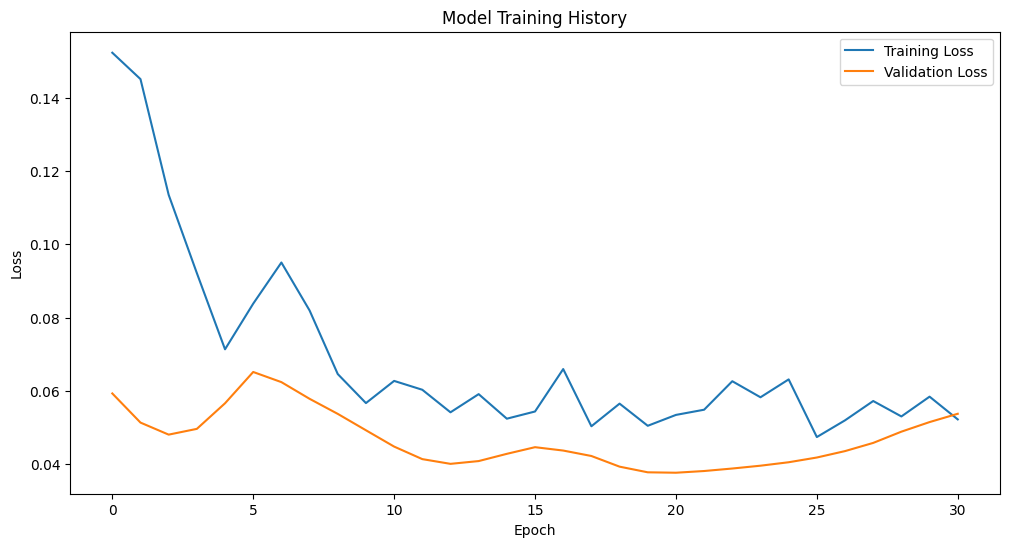

C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:34:40.903501
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.76°C
Predicted Humidity: 63.58%
Predicted Wind Speed: 4.78 m/s
Forecast Accuracy: 0.95
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


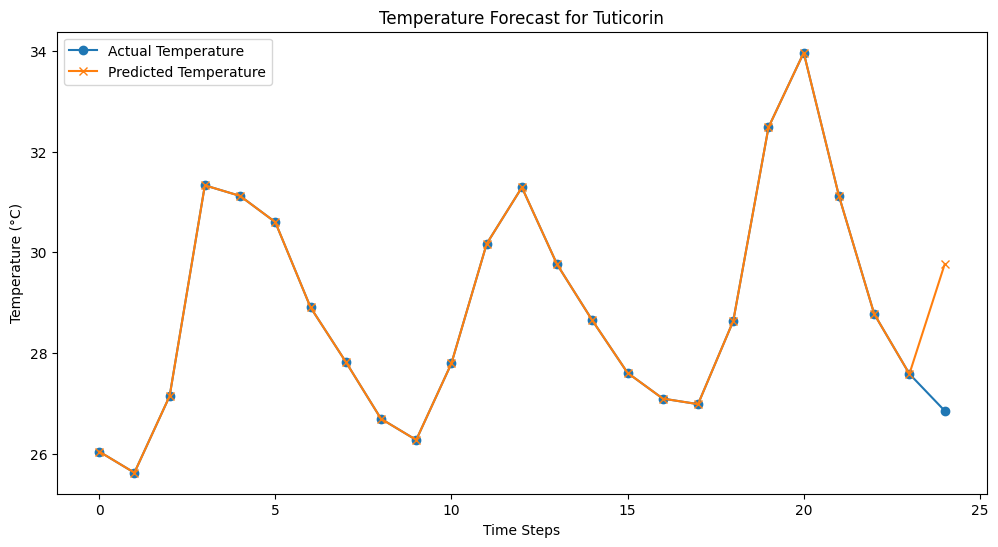

2024-10-13 02:34:41,001 - INFO - Forecast completed with R2 score: 0.95


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0529 - mae: 0.1961 - val_loss: 0.0386 - val_mae: 0.1721
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0659 - mae: 0.2081 - val_loss: 0.0399 - val_mae: 0.1748
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0539 - mae: 0.1900 - val_loss: 0.0421 - val_mae: 0.1787
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0518 - mae: 0.1933 - val_loss: 0.0448 - val_mae: 0.1831
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0591 - mae: 0.2008 - val_loss: 0.0476 - val_mae: 0.1875
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0477 - mae: 0.1832 - val_loss: 0.0503 - val_mae: 0.1917
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0557 - mae: 0.1973 - val_loss: 0.0525 - val_mae: 0.1957
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0532 - mae: 0.1910 - val_loss: 0.0536 - val_mae: 0.1979
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0519 - mae:

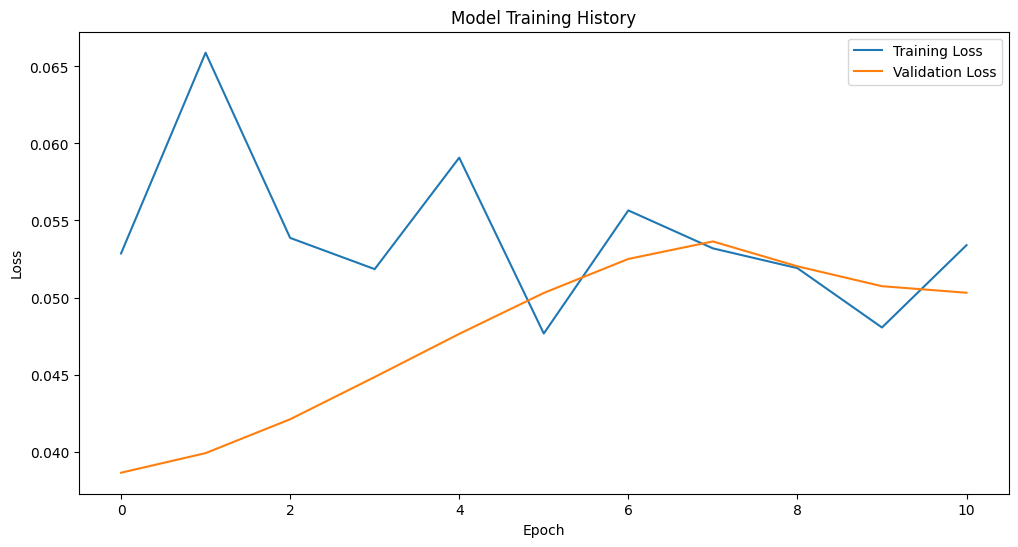

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:36:43.824694
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.91°C
Predicted Humidity: 63.84%
Predicted Wind Speed: 4.86 m/s
Forecast Accuracy: 0.96
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


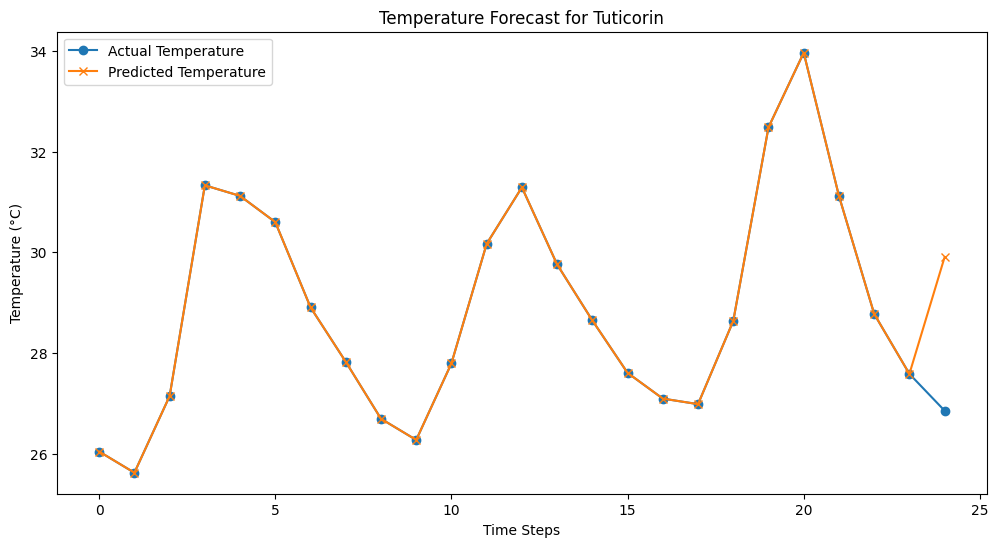

2024-10-13 02:36:43,931 - INFO - Forecast completed with R2 score: 0.96


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0618 - mae: 0.2004 - val_loss: 0.0390 - val_mae: 0.1731
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0556 - mae: 0.1904 - val_loss: 0.0398 - val_mae: 0.1749
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0588 - mae: 0.1944 - val_loss: 0.0411 - val_mae: 0.1775
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0516 - mae: 0.1970 - val_loss: 0.0424 - val_mae: 0.1801
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0528 - mae: 0.1832 - val_loss: 0.0442 - val_mae: 0.1838
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0523 - mae: 0.1871 - val_loss: 0.0462 - val_mae: 0.1878
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0520 - mae: 0.2015 - val_loss: 0.0478 - val_mae: 0.1912
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0487 - mae: 0.1874 - val_loss: 0.0506 - val_mae: 0.1960
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0570 - mae: 

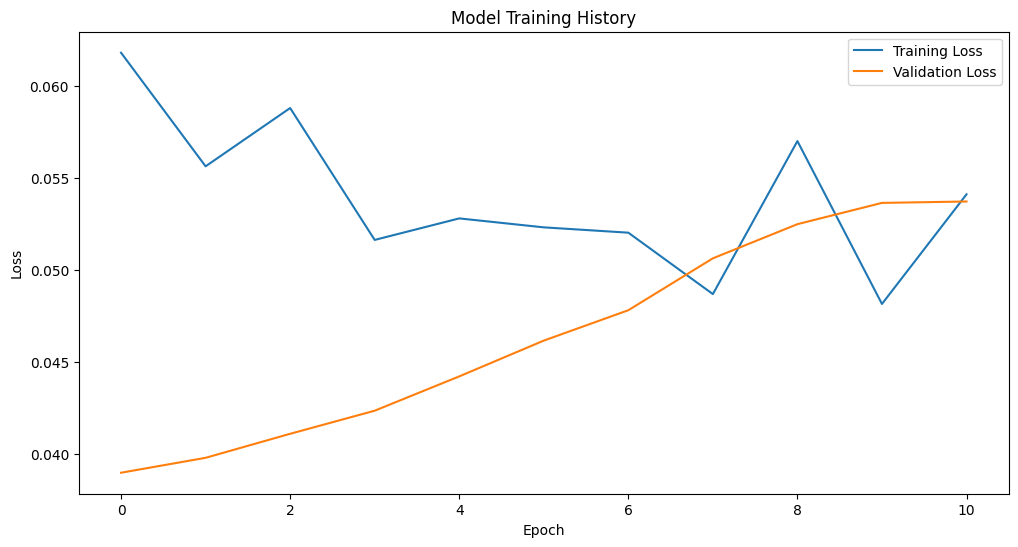

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:38:46.727192
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.93°C
Predicted Humidity: 63.85%
Predicted Wind Speed: 4.86 m/s
Forecast Accuracy: 0.96
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


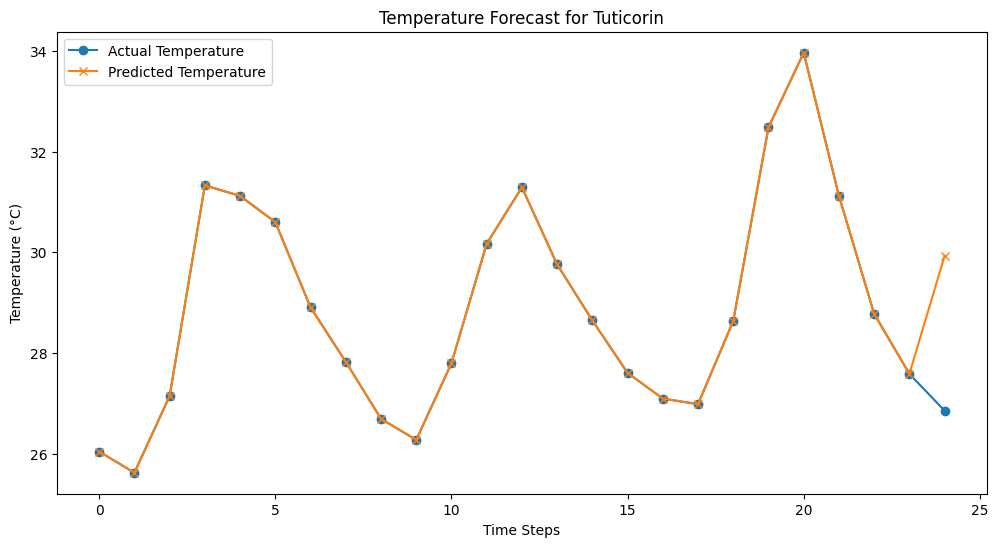

2024-10-13 02:38:46,822 - INFO - Forecast completed with R2 score: 0.96


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0512 - mae: 0.1859 - val_loss: 0.0393 - val_mae: 0.1525
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0454 - mae: 0.1719 - val_loss: 0.0454 - val_mae: 0.1647
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0429 - mae: 0.1634 - val_loss: 0.0520 - val_mae: 0.1777
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0376 - mae: 0.1569 - val_loss: 0.0587 - val_mae: 0.1905
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0349 - mae: 0.1518 - val_loss: 0.0654 - val_mae: 0.2054
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0359 - mae: 0.1478 - val_loss: 0.0713 - val_mae: 0.2193
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0367 - mae: 0.1540 - val_loss: 0.0742 - val_mae: 0.2254
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0337 - mae: 0.1440 - val_loss: 0.0744 - val_mae: 0.2263
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0328 - mae: 

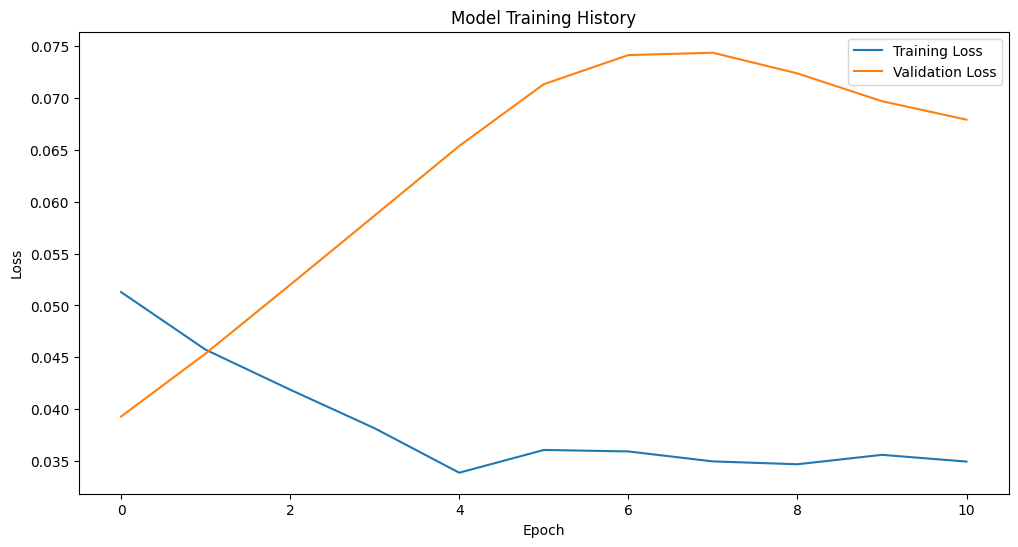

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:40:49.527896
Current Temperature: 25.68°C
Current Humidity: 88.00%
Current Wind Speed: 4.37 m/s
Predicted Temperature: 30.07°C
Predicted Humidity: 65.96%
Predicted Wind Speed: 4.83 m/s
Forecast Accuracy: 0.95
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


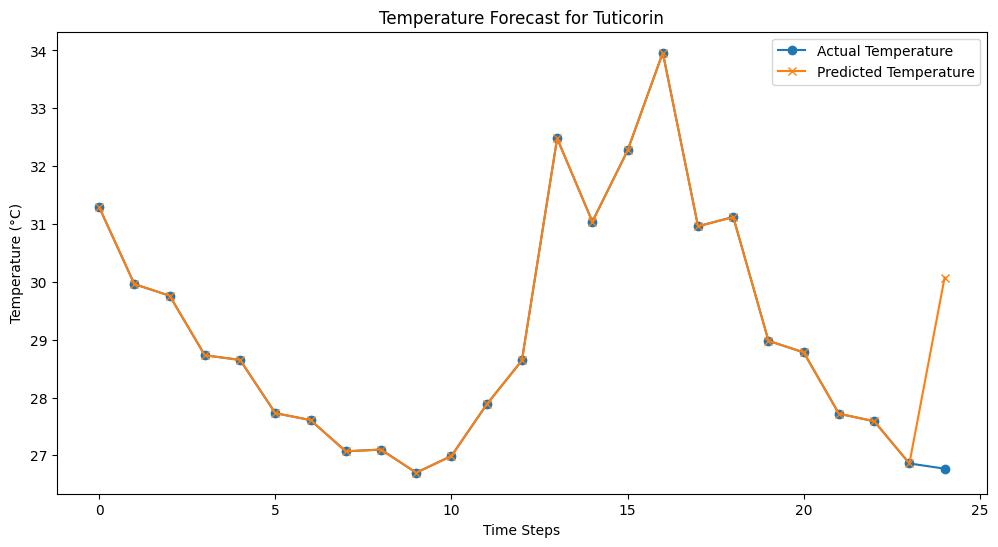

2024-10-13 02:40:49,628 - INFO - Forecast completed with R2 score: 0.95


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0468 - mae: 0.1714 - val_loss: 0.0468 - val_mae: 0.1702
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0450 - mae: 0.1672 - val_loss: 0.0526 - val_mae: 0.1816
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0374 - mae: 0.1572 - val_loss: 0.0569 - val_mae: 0.1906
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0371 - mae: 0.1530 - val_loss: 0.0601 - val_mae: 0.1967
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0340 - mae: 0.1444 - val_loss: 0.0628 - val_mae: 0.2013
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0335 - mae: 0.1442 - val_loss: 0.0655 - val_mae: 0.2080
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0342 - mae: 0.1497 - val_loss: 0.0683 - val_mae: 0.2138
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0322 - mae: 0.1446 - val_loss: 0.0706 - val_mae: 0.2191
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0320 - mae: 

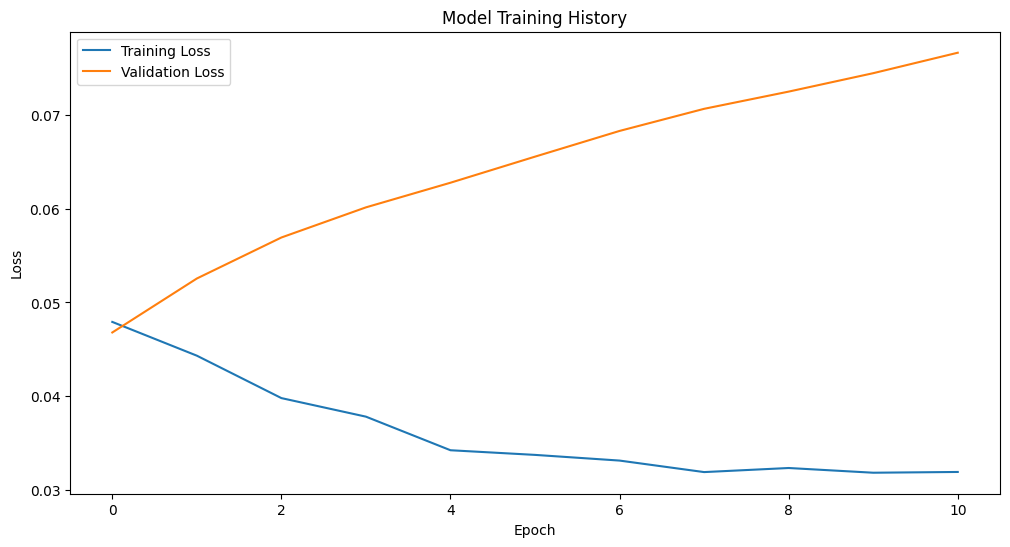

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:42:52.539354
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.72°C
Predicted Humidity: 65.52%
Predicted Wind Speed: 4.54 m/s
Forecast Accuracy: 0.95
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


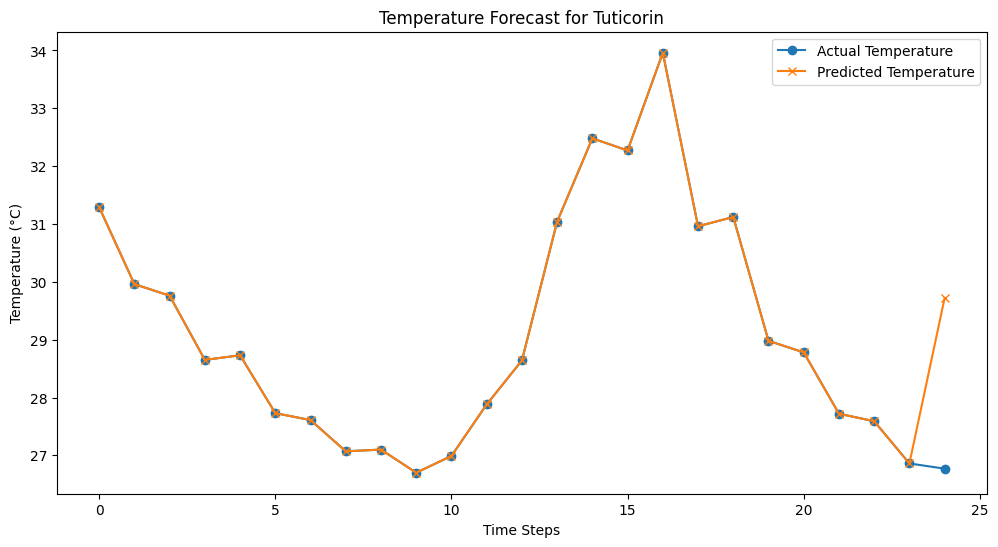

2024-10-13 02:42:52,683 - INFO - Forecast completed with R2 score: 0.95


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0433 - mae: 0.1656 - val_loss: 0.0468 - val_mae: 0.1686
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0395 - mae: 0.1608 - val_loss: 0.0499 - val_mae: 0.1755
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0391 - mae: 0.1572 - val_loss: 0.0531 - val_mae: 0.1827
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0369 - mae: 0.1557 - val_loss: 0.0560 - val_mae: 0.1885
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0330 - mae: 0.1457 - val_loss: 0.0579 - val_mae: 0.1931
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0342 - mae: 0.1524 - val_loss: 0.0600 - val_mae: 0.1990
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0339 - mae: 0.1494 - val_loss: 0.0621 - val_mae: 0.2037
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0341 - mae: 0.1481 - val_loss: 0.0639 - val_mae: 0.2076
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0310 - mae: 

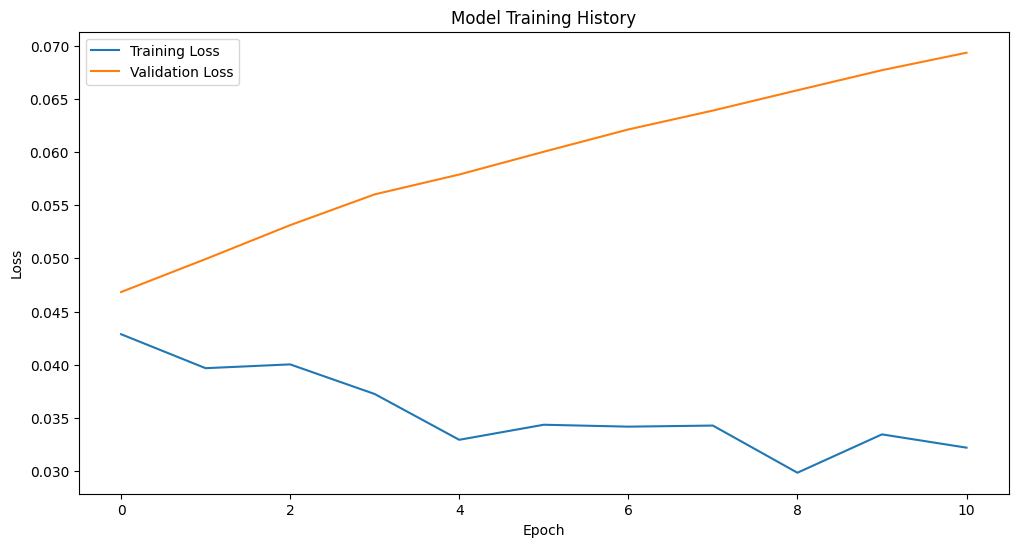

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:44:55.663492
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.43°C
Predicted Humidity: 65.48%
Predicted Wind Speed: 4.32 m/s
Forecast Accuracy: 0.95
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


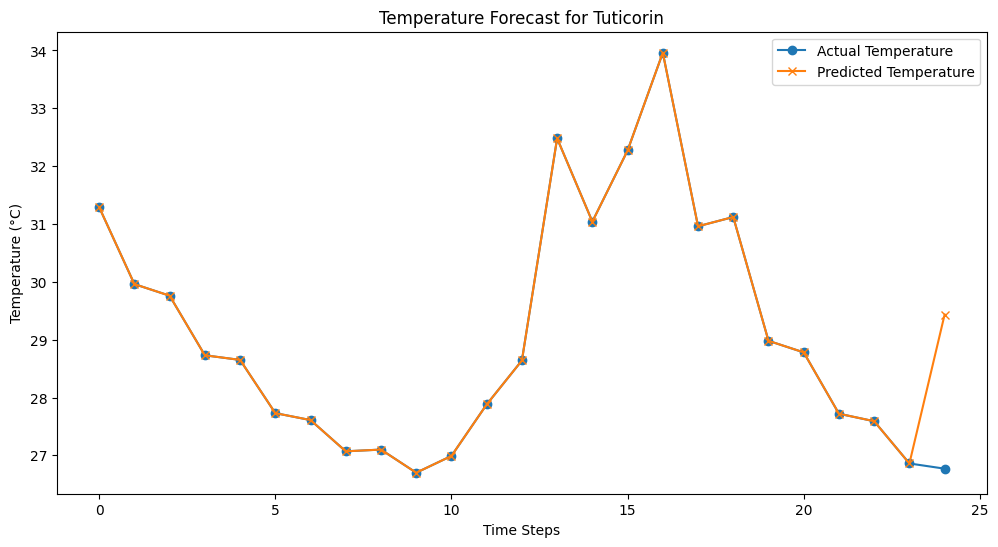

2024-10-13 02:44:55,771 - INFO - Forecast completed with R2 score: 0.95


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0391 - mae: 0.1616 - val_loss: 0.0527 - val_mae: 0.1824
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0377 - mae: 0.1563 - val_loss: 0.0551 - val_mae: 0.1873
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0378 - mae: 0.1583 - val_loss: 0.0571 - val_mae: 0.1919
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0366 - mae: 0.1522 - val_loss: 0.0605 - val_mae: 0.1977
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0327 - mae: 0.1492 - val_loss: 0.0653 - val_mae: 0.2084
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0315 - mae: 0.1485 - val_loss: 0.0706 - val_mae: 0.2192
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0314 - mae: 0.1433 - val_loss: 0.0755 - val_mae: 0.2292
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0317 - mae: 0.1440 - val_loss: 0.0782 - val_mae: 0.2338
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0319 - mae:

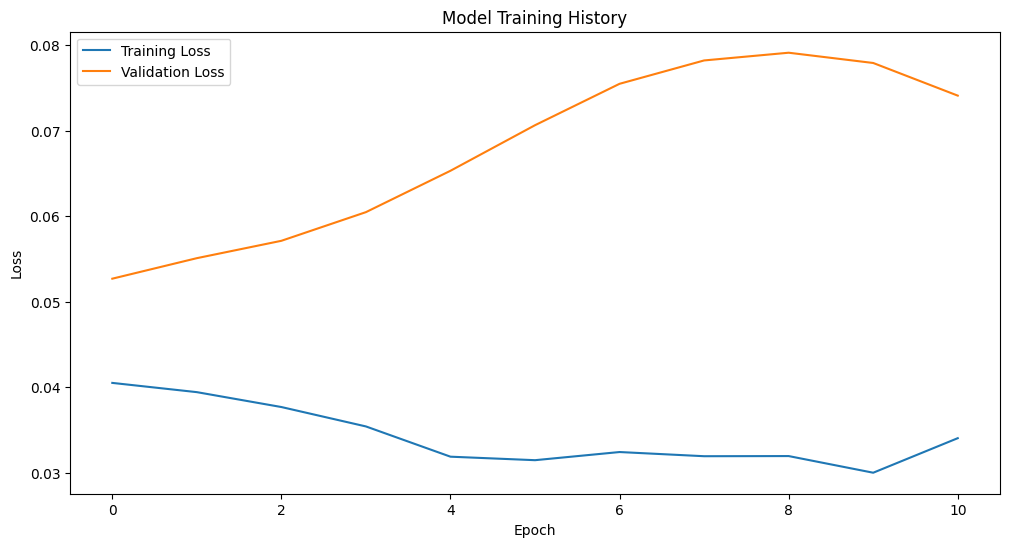

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:47:00.439433
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.35°C
Predicted Humidity: 65.44%
Predicted Wind Speed: 4.20 m/s
Forecast Accuracy: 0.95
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


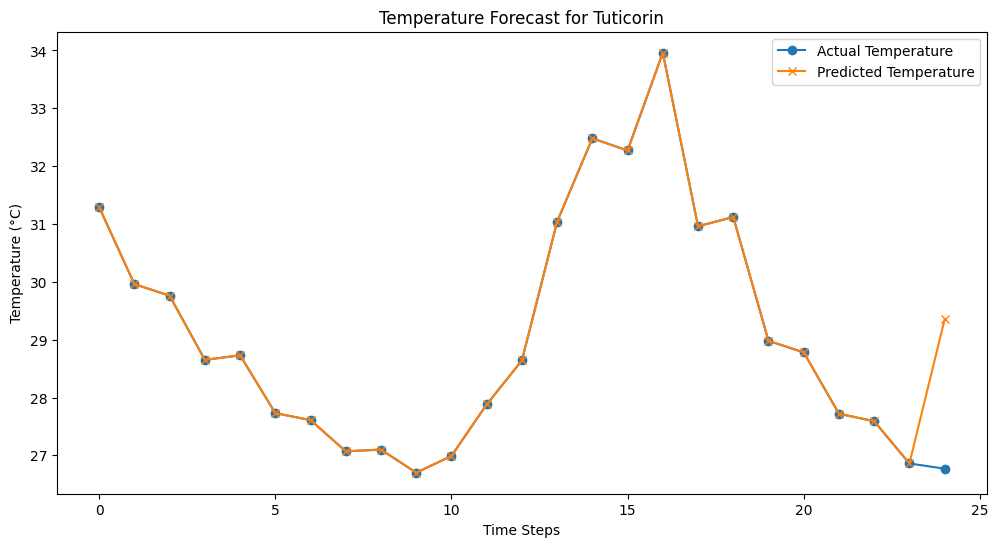

2024-10-13 02:47:00,655 - INFO - Forecast completed with R2 score: 0.95


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0431 - mae: 0.1645 - val_loss: 0.0475 - val_mae: 0.1704
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0396 - mae: 0.1584 - val_loss: 0.0465 - val_mae: 0.1686
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0359 - mae: 0.1518 - val_loss: 0.0473 - val_mae: 0.1699
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0373 - mae: 0.1550 - val_loss: 0.0505 - val_mae: 0.1765
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0361 - mae: 0.1529 - val_loss: 0.0547 - val_mae: 0.1860
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0343 - mae: 0.1454 - val_loss: 0.0586 - val_mae: 0.1942
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0354 - mae: 0.1496 - val_loss: 0.0617 - val_mae: 0.2009
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0324 - mae: 0.1415 - val_loss: 0.0641 - val_mae: 0.2058
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0332 - mae:

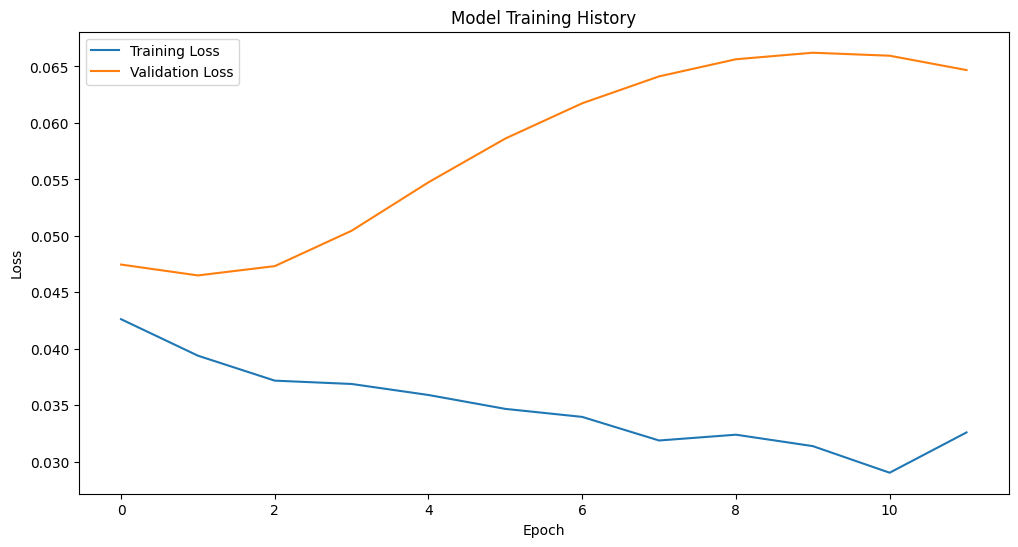

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:49:05.285974
Current Temperature: 26.93°C
Current Humidity: 78.00%
Current Wind Speed: 2.65 m/s
Predicted Temperature: 29.71°C
Predicted Humidity: 67.24%
Predicted Wind Speed: 4.33 m/s
Forecast Accuracy: 0.96
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


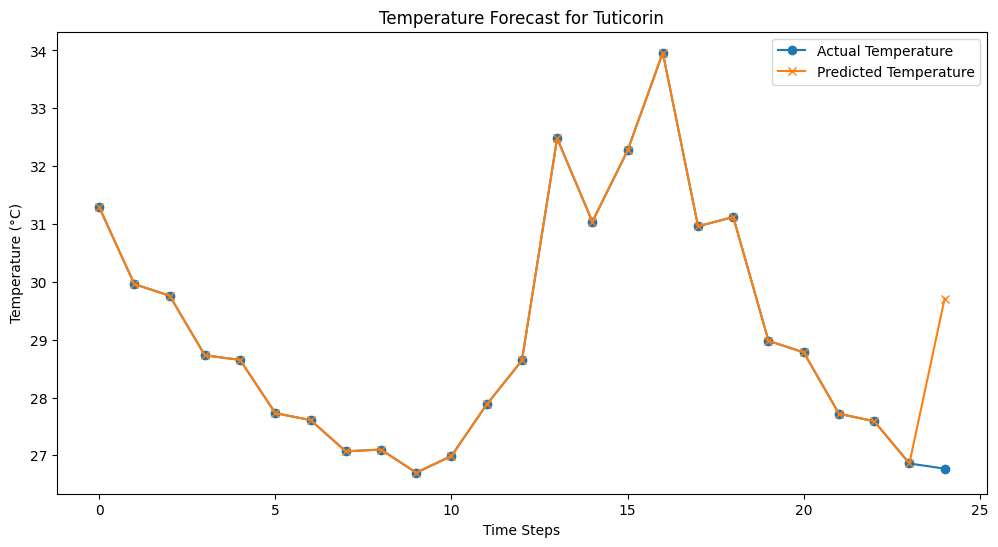

2024-10-13 02:49:05,494 - INFO - Forecast completed with R2 score: 0.96


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0386 - mae: 0.1595 - val_loss: 0.0502 - val_mae: 0.1771
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0295 - mae: 0.1360 - val_loss: 0.0517 - val_mae: 0.1802
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0347 - mae: 0.1490 - val_loss: 0.0547 - val_mae: 0.1864
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0329 - mae: 0.1486 - val_loss: 0.0582 - val_mae: 0.1930
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0336 - mae: 0.1457 - val_loss: 0.0618 - val_mae: 0.2003
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0306 - mae: 0.1434 - val_loss: 0.0644 - val_mae: 0.2062
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0308 - mae: 0.1440 - val_loss: 0.0658 - val_mae: 0.2095
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0306 - mae: 0.1421 - val_loss: 0.0668 - val_mae: 0.2117
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0271 - mae:

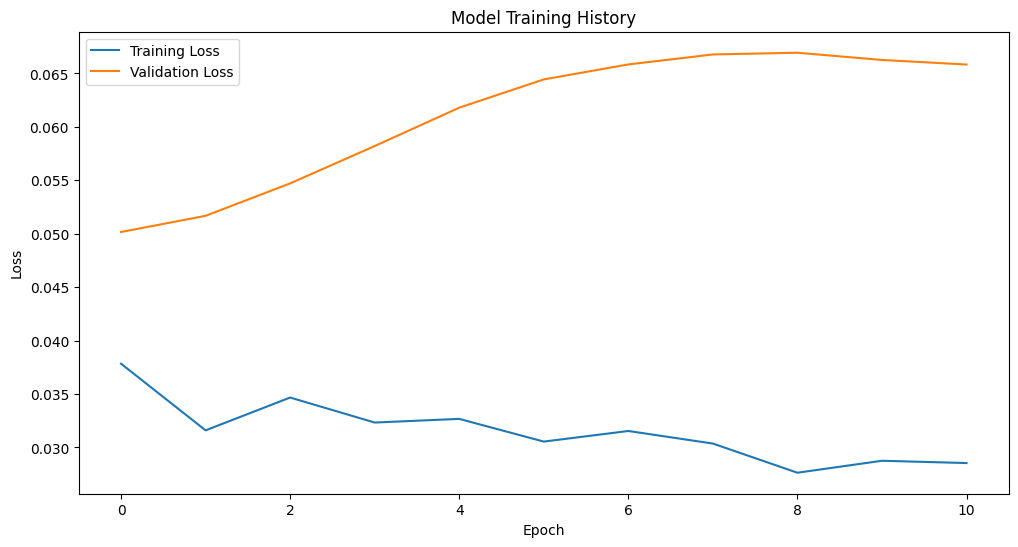

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:51:09.592367
Current Temperature: 25.68°C
Current Humidity: 88.00%
Current Wind Speed: 4.37 m/s
Predicted Temperature: 29.79°C
Predicted Humidity: 67.51%
Predicted Wind Speed: 4.34 m/s
Forecast Accuracy: 0.96
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


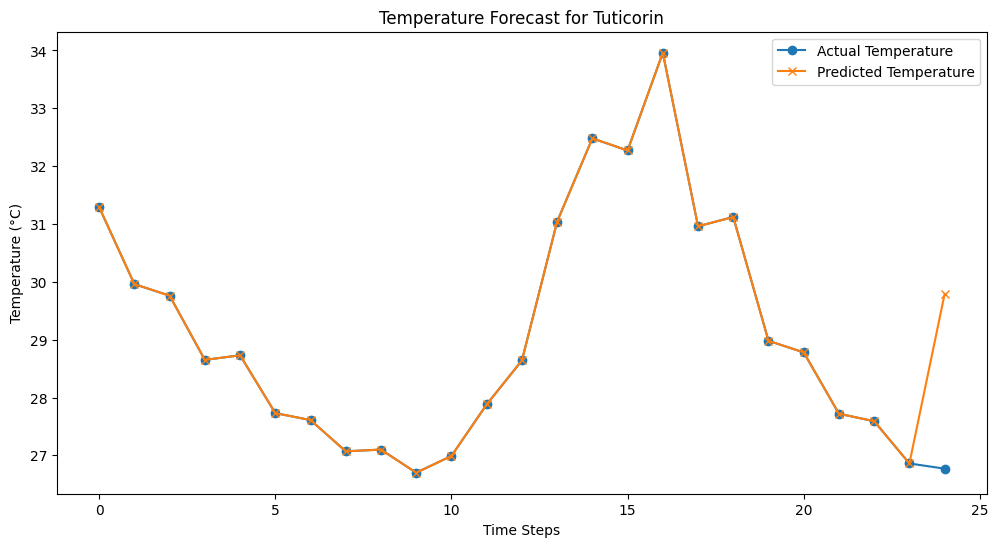

2024-10-13 02:51:09,812 - INFO - Forecast completed with R2 score: 0.96


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0359 - mae: 0.1553 - val_loss: 0.0479 - val_mae: 0.1722
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0364 - mae: 0.1517 - val_loss: 0.0507 - val_mae: 0.1780
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0333 - mae: 0.1437 - val_loss: 0.0522 - val_mae: 0.1817
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0342 - mae: 0.1498 - val_loss: 0.0522 - val_mae: 0.1824
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0331 - mae: 0.1471 - val_loss: 0.0524 - val_mae: 0.1829
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0302 - mae: 0.1379 - val_loss: 0.0543 - val_mae: 0.1879
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0337 - mae: 0.1446 - val_loss: 0.0583 - val_mae: 0.1971
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0322 - mae: 0.1465 - val_loss: 0.0639 - val_mae: 0.2075
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0291 - mae:

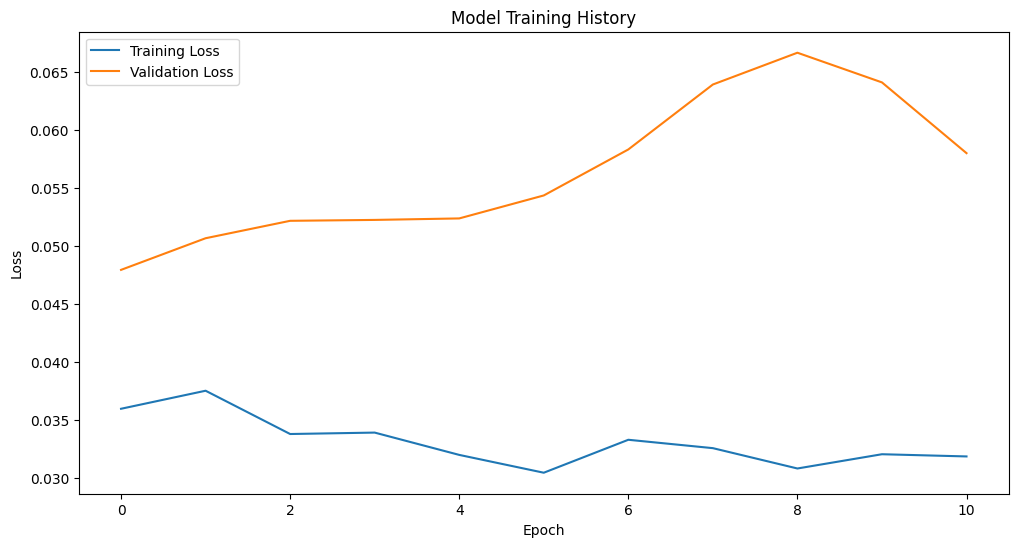

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\sanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Storing the following data in the database:
Location: Tuticorin
Timestamp: 2024-10-13 02:53:14.317842
Current Temperature: 25.68°C
Current Humidity: 88.00%
Current Wind Speed: 4.37 m/s
Predicted Temperature: 29.59°C
Predicted Humidity: 66.80%
Predicted Wind Speed: 4.23 m/s
Forecast Accuracy: 0.96
Map Link: https://www.google.com/maps/@8.8059955,78.1553488,10z


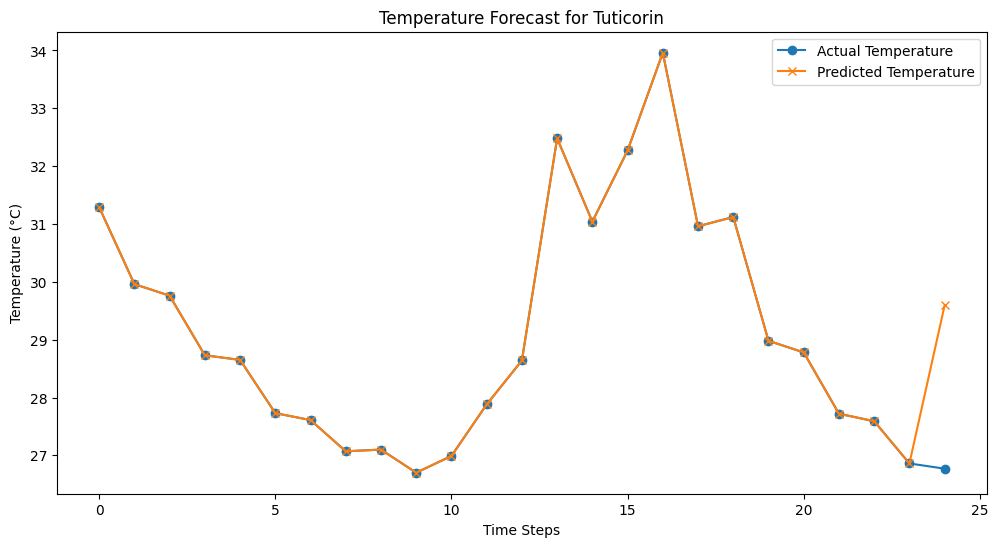

2024-10-13 02:53:14,549 - INFO - Forecast completed with R2 score: 0.96


In [ ]:
def main():
    location = input("Enter a location for weather forecasting: ")
    try:
        forecaster = WeatherForecaster(location)
        while True:
            forecaster.run_forecast()
            time.sleep(120)  # Wait for 1 hour
    except Exception as e:
        logging.error(f"An error occurred: {e}")
    finally:
        if 'forecaster' in locals():
            forecaster.close_connection()

if __name__ == "__main__":
    main()